# Implementation of a local image warping augmentation
The following is an implementation of the paper [A new data augmentation method based on local image warping for medical
image segmentation](https://pubmed.ncbi.nlm.nih.gov/33300190/). The augmentation techniques described in the paper are implemented as Pytorch `transforms`.

We will test the implemented augmentation techniques using images from the [Foot Ulcer Segmentation Challenge](https://github.com/uwm-bigdata/wound-segmentation/tree/master/data/Foot%20Ulcer%20Segmentation%20Challenge).

In [1]:
from ipywidgets import *
from matplotlib import pyplot as plt
%matplotlib inline

import wrp_aug as tf
import dataset as ds

import importlib
importlib.reload(tf)
importlib.reload(ds)

import cv2
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF
importlib.reload(T)
import torch


In [2]:
def plot_examples(dataset):
    figure = plt.figure(figsize=(15,15))
    cols, rows = 2, 1
    for i in range(1, cols * rows + 1, 2):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, seg = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img)

        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(seg, cmap='gray')
    plt.show()

def drawVectorField(map, step=4, cropOrigin=(-1, -1), cropRegion=(512, 512)):
    img = np.ones((cropRegion[0], cropRegion[1], 1), np.uint8) * 255
    height, width = img.shape[:2]
    y, x = (
        np.mgrid[step / 2 : height : step, step / 2 : width : step]
        .reshape(2, -1)
        .astype(int)
    )
    fy, fx = map[y + cropOrigin[0], x + cropOrigin[1]].T
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for (x1, y1), (x2, y2) in lines:
        cv2.arrowedLine(vis, (x1, y1), (x2, y2), (90, 90, 90), 1, tipLength=0.6)
    return vis

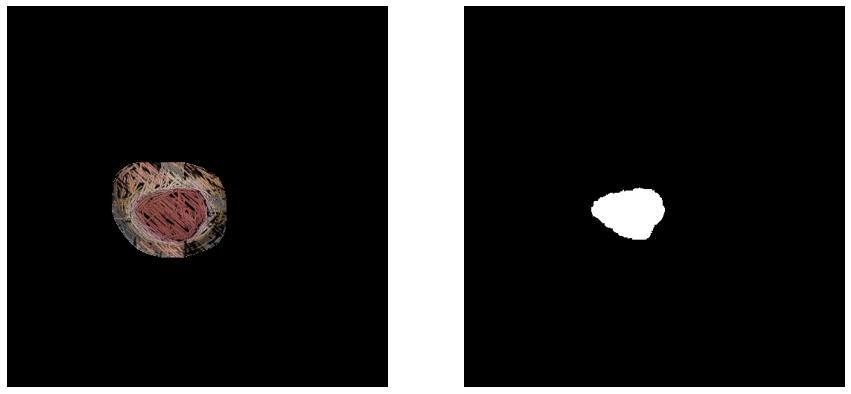

In [3]:
IMAGES_PATH = "data/train/images"
SEGMENTATIONS_PATH = "data/train/labels"

dataset = ds.FootUlcerSegmentationDataset(IMAGES_PATH, SEGMENTATIONS_PATH)
plot_examples(dataset)

Next, we'll apply our transformations. We set `N` to the amount of desired warpings in a circular fashion. For `outwards=True` the deterioration process is modeled. For `outwards=False` the healing process is modeled.

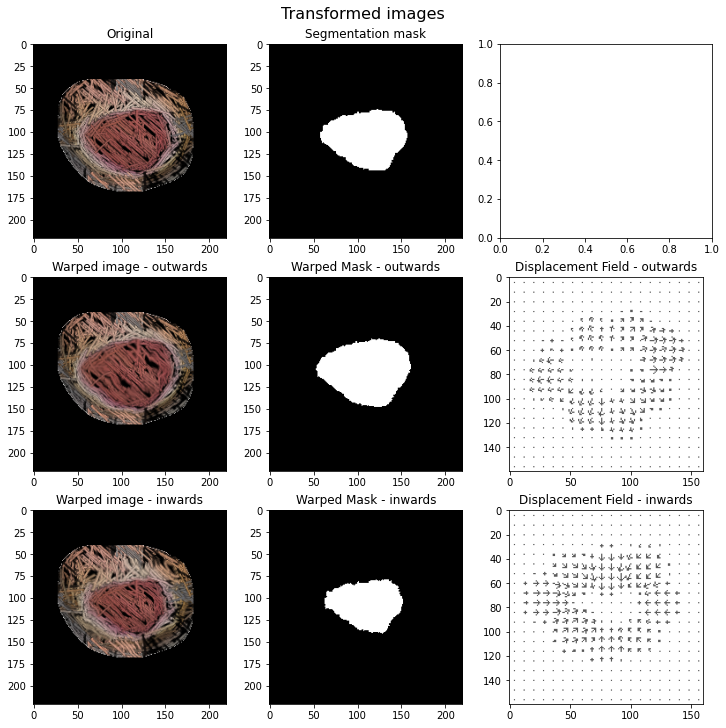

In [8]:
importlib.reload(tf)
fig = None

fig, axs = plt.subplots(3, 3,figsize=(10, 10), constrained_layout=True)

def update(N = 8):
    fig.suptitle('Transformed images', fontsize=16)

    outwardsWarping = tf.CircularWarping(N, outwards=True)
    transforms = T.Compose([outwardsWarping])

    outwardsDataset_aug = ds.FootUlcerSegmentationDataset(
        IMAGES_PATH, SEGMENTATIONS_PATH, transform=transforms)

    inwardsWarping = tf.CircularWarping(N, outwards=False)
    transforms = T.Compose([inwardsWarping])
    inwardsDataset_aug = ds.FootUlcerSegmentationDataset(
        IMAGES_PATH, SEGMENTATIONS_PATH, transform=transforms)

    orig, origSeg = dataset[0]
    out_aug, out_augSeg = outwardsDataset_aug[0]
    inw_aug, inw_augSeg = inwardsDataset_aug[0]

    axs[0,0].imshow(orig[170:391, 113:333, :])
    axs[0,0].set_title("Original")
    axs[0,1].imshow(origSeg[170:391, 113:333, :], cmap='gray')
    axs[0,1].set_title("Segmentation mask")
    axs[1,0].imshow(out_aug[170:391, 113:333, :])
    axs[1,0].set_title('Warped image - outwards')
    axs[1,1].imshow(out_augSeg[170:391, 113:333, :], cmap='gray')
    axs[1,1].set_title("Warped Mask - outwards")
    axs[1,2].imshow(drawVectorField(outwardsWarping.lastMap, 8, (200, 143), (160, 160)))
    axs[1,2].set_title("Displacement Field - outwards")

    axs[2,0].imshow(inw_aug[170:391, 113:333, :])
    axs[2,0].set_title('Warped image - inwards')
    axs[2,1].imshow(inw_augSeg[170:391, 113:333, :], cmap='gray')
    axs[2,1].set_title("Warped Mask - inwards")
    axs[2,2].imshow(drawVectorField(inwardsWarping.lastMap, 8, (200, 143), (160, 160)))
    axs[2,2].set_title("Displacement Field - inwards")

update(8)